Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# @title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Action-Angle Networks



In [2]:
%pwd

'/Users/ameyad/Documents/google-research/action_angle_networks'

In [3]:
# @title Base Imports
from typing import *
import functools
import sys
import tempfile

from absl import logging
import collections
import chex
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.core import frozen_dict
from flax.training import train_state
import optax
import distrax
import tensorflow as tf
import ml_collections
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

sys.path.append("..")
matplotlib.rc("animation", html="jshtml")
logging.get_absl_handler().python_handler.stream = sys.stdout
logging.set_verbosity(logging.INFO)

In [4]:
# @title Source Imports
%load_ext autoreload
%autoreload 2
import harmonic_motion_simulation
import models
import train
from configs.harmonic_motion import action_angle_flow

In [5]:
%load_ext tensorboard

## Coupled Harmonic Oscillators

Consider a system of $n$ particles with masses $m_1, m_2, ..., m_n$.
Each particle is connected to a wall with a spring of spring constant $k$,
and every pair of particles is connected to each other with a spring of spring constant $\kappa$.
Then, the equations of motion take the following form:
$$
m_1\frac{\partial^2 q_i}{\partial t^2} = -(k + \kappa) q_i + \sum_{j \neq i}\kappa q_j
$$
for each $i \in \{1, 2 ..., n\}$.

To find the normal modes where all particles oscillate with the same angular frequency $\omega$, we make the exponential ansatz:
$$
q_i = c_ie^{i\omega t}
$$
for each $i \in \{1, 2 ..., n\}$.

This gives us:
$$
-\omega^2c_i = -\frac{k + \kappa}{m_i}c_i + \sum_{j \neq i}\frac{\kappa}{m_i}c_j
$$
for each $i \in \{1, 2 ..., n\}$.
In a matrix form, the coefficients $c$ satisfy
$$
(M + \omega^2I_n)c = 0
$$
where $M$ is the matrix such that
$M_{ii} = -\frac{k + \kappa}{m_i}$ and $M_{ij} = \frac{\kappa}{m_i}$ for $i \neq j$.

Thus, the angular frequencies $\omega$ are the square roots of the negative
eigenvalues of $M$.

In [16]:
simulation_parameters = {
    "m": jnp.asarray([2.0, 10.0]),
    "k_wall": jnp.asarray([10.0, 4.0]),
    "k_pair": jnp.asarray([1.0, 1.0]),
    "A": jnp.asarray([3.0, 1.0]),
    "phi": jnp.asarray([jnp.pi / 2, 0.0]),
}

In [17]:
# Generate coordinates at multiple instants of time!
times = jnp.arange(100) * 1
positions, momentums = jax.vmap(
    harmonic_motion_simulation.generate_canonical_coordinates,
    in_axes=(0, None),
    out_axes=0,
)(times, simulation_parameters)

In [18]:
# Compute Hamiltonians at the different instants.
hamiltonians = jax.vmap(
    harmonic_motion_simulation.compute_hamiltonian, in_axes=(0, 0, None)
)(positions, momentums, simulation_parameters)
hamiltonians

DeviceArray([52.099583, 52.099586, 52.099586, 52.09959 , 52.099586,
             52.099583, 52.099594, 52.099586, 52.099575, 52.099583,
             52.099594, 52.099586, 52.09959 , 52.09959 , 52.099586,
             52.099583, 52.09958 , 52.099583, 52.09959 , 52.09958 ,
             52.099583, 52.099594, 52.099586, 52.099586, 52.09958 ,
             52.099586, 52.099583, 52.099583, 52.099583, 52.099583,
             52.09958 , 52.09958 , 52.099586, 52.099583, 52.099586,
             52.099583, 52.099575, 52.09959 , 52.09959 , 52.099583,
             52.099583, 52.099586, 52.099586, 52.09958 , 52.099583,
             52.09959 , 52.09958 , 52.09958 , 52.09958 , 52.099586,
             52.099586, 52.099583, 52.099583, 52.099583, 52.099594,
             52.09959 , 52.099583, 52.09958 , 52.09959 , 52.09959 ,
             52.099586, 52.09959 , 52.099583, 52.099583, 52.099583,
             52.09958 , 52.099583, 52.099583, 52.099583, 52.099586,
             52.099586, 52.099583, 52.099586, 52

In [12]:
import flax
from clu import checkpoint

ckpt = checkpoint.Checkpoint("tmp-checkpoint", max_to_keep=2)
ckpt.save(dict(x={"params": 1, "vals": 5}, y={"s": 10}))

INFO:absl:Checkpoint.save() ...
INFO:absl:Storing next checkpoint 'tmp-checkpoint/ckpt-1'
INFO:absl:Checkpoint.save() finished after 0.01s.


'tmp-checkpoint/ckpt-1'

In [14]:
vals = ckpt.restore("tmp-checkpoint")
vals

INFO:absl:Restoring checkpoint: tmp-checkpoint/ckpt-1
INFO:absl:Restored save_counter=1 restored_checkpoint=tmp-checkpoint/ckpt-1


{'x': {'params': 1, 'vals': 5}, 'y': {'s': 10}}

## Training Models

You can train a model below, or just load a model by specifying its `workdir`!

In [6]:
# @title Training Configuration
config = action_angle_flow.get_config()
workdir = "/Users/ameyad/Documents/google-research/tmp/action_angle_networks/configs/harmonic_motion/action_angle_flow/k_pair_1."

In [7]:
%tensorboard --logdir={workdir} --port=0

In [8]:
scaler, state, aux = train.train_and_evaluate(config, workdir)

INFO:absl:[Hyperparameters] {'activation': 'sigmoid', 'batch_size': 100, 'encoder_decoder_type': 'flow', 'eval_cadence': 50, 'flow_type': 'shear', 'latent_size': 100, 'learning_rate': 0.001, 'model': 'action-angle-network', 'num_flow_layers': 10, 'num_samples': 1000, 'num_train_steps': 5000, 'num_trajectories': 2, 'polar_action_angles': True, 'regularizations': {'actions': 1.0, 'angular_velocities': 0.0, 'encoded_decoded_differences': 0.0}, 'rng_seed': 0, 'scaler': 'standard', 'simulation': 'harmonic', 'simulation_parameter_ranges': {'A': (1, 10), 'k_pair': (0,), 'k_wall': (0.005, 0.01), 'm': (1, 5), 'phi': (0, 1)}, 'single_step_predictions': True, 'split_on': 'times', 'test_time_jumps': (1, 2, 5, 10, 20, 50), 'time_delta': 1.0, 'train_split_proportion': 0.08, 'train_time_jump_range': (1, 10), 'train_time_jump_schedule': 'linear'}
INFO:absl:Generating data.
INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not i

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/Users/ameyad/Documents/google-research/action_angle_networks/../action_angle_networks/harmonic_motion_simulation.py:36: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  ranges_flat, ranges_treedef = jax.tree_flatten(
/Users/ameyad/Documents/google-research/action_angle_networks/../action_angle_networks/harmonic_motion_simulation.py:41: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  rng_tree = jax.tree_unflatten(ranges_treedef, rngs)
INFO:absl:Constructing model.
INFO:absl:
+-----------------------------------------------+----------+------+-----------+---------+
| Name                                          | Shape    | Size | Mean      | Std     |
+-----------------------------------------------+----------+------+-----------+---------+
| params/angular_velocity_net/Dense_0/bias      | (100,)   | 100  | 0.0       | 0.0

In [23]:
train_positions = aux["train"]["positions"]
train_momentums = aux["train"]["momentums"]
train_simulation_parameters = aux["train"]["simulation_parameters"]
all_train_metrics = aux["train"]["metrics"]

test_positions = aux["test"]["positions"]
test_momentums = aux["test"]["momentums"]
test_simulation_parameters = aux["test"]["simulation_parameters"]
all_test_metrics = aux["test"]["metrics"]

### Plotting Loss



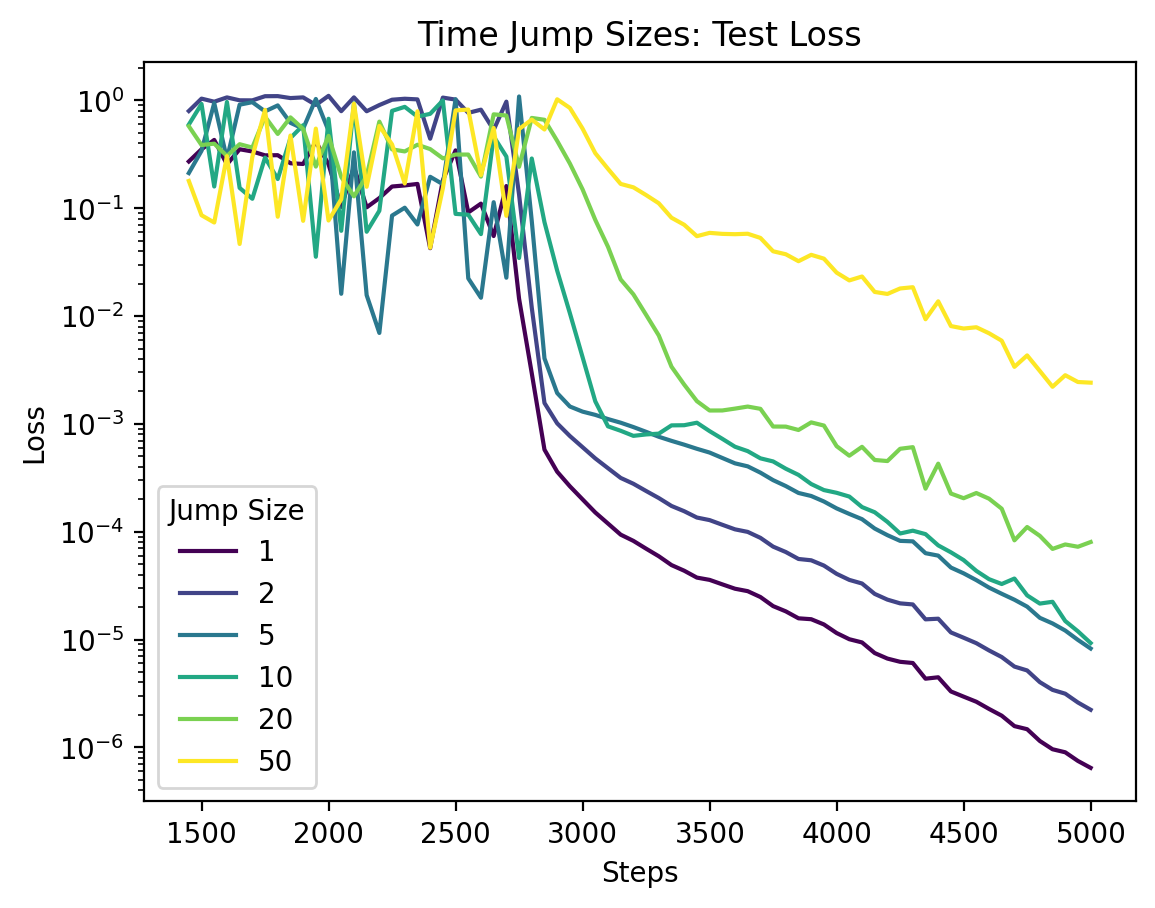

In [24]:
%config InlineBackend.figure_format = 'retina'

metrics = all_test_metrics
total_losses = {
    jump: np.asarray(list(metrics[step][jump]["prediction_loss"] for step in metrics))
    for jump in config.test_time_jumps
}
steps = list(metrics.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(total_losses)))

fig, ax = plt.subplots()
for jump_color, jump in zip(colors, config.test_time_jumps):
    total_losses_for_jump = total_losses[jump]
    ax.plot(steps, total_losses_for_jump, label=jump, color=jump_color)

ax.set_title("Time Jump Sizes: Test Loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")
ax.set_yscale("log")
# ax.set_xscale('log')
ax.legend(title="Jump Size")
plt.show()

In [ ]:
fig.savefig("test_losses.pdf", dpi=1000)
files.download("test_losses.pdf")

### Plotting Change in Hamiltonians

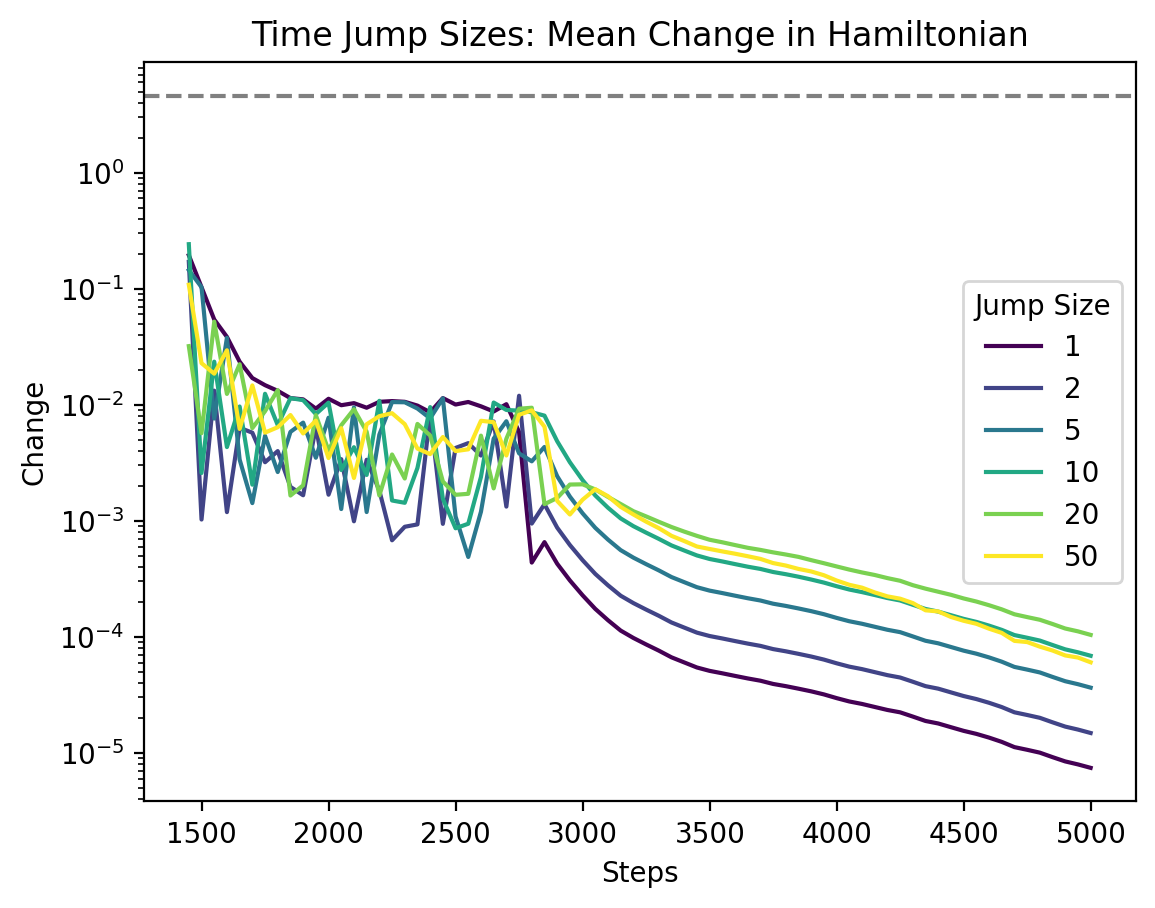

In [26]:
%config InlineBackend.figure_format = 'retina'

metrics = all_test_metrics
total_changes = {
    jump: np.asarray(
        list(metrics[step][jump]["mean_change_in_hamiltonians"] for step in metrics)
    )
    for jump in config.test_time_jumps
}
steps = list(metrics.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(total_changes)))

fig, ax = plt.subplots()
for jump_color, jump in zip(colors, config.test_time_jumps):
    total_changes_for_jump = total_changes[jump]
    ax.plot(steps, total_changes_for_jump, label=jump, color=jump_color)

true_position, true_momentum = train.inverse_transform_with_scaler(
    test_positions[0, :1], test_momentums[0, :1], scaler
)
actual_hamiltonian = harmonic_motion_simulation.compute_hamiltonian(
    true_position, true_momentum, simulation_parameters
)
actual_hamiltonian = np.asarray(actual_hamiltonian).squeeze()
ax.axhline(y=actual_hamiltonian, c="gray", linestyle="--")
ax.set_title("Time Jump Sizes: Mean Change in Hamiltonian")
ax.set_xlabel("Steps")
ax.set_ylabel("Change")
ax.set_yscale("log")
# ax.set_xscale('log')
ax.legend(title="Jump Size")
plt.show()

In [ ]:
fig.savefig("test_change_in_hamiltonian.pdf", dpi=1000)
files.download("test_change_in_hamiltonian.pdf")

### Plotting Action and Angle Space

In [29]:
# Sample position-momentum space.
max_position = 1.2 * np.abs(train_positions).max()
max_momentum = 1.2 * np.abs(train_momentums).max()
plot_positions = jnp.linspace(-max_position, max_position, num=100)
plot_momentums = jnp.linspace(-max_momentum, max_momentum, num=100)
grid = jnp.meshgrid(plot_positions, plot_momentums)
plot_positions = grid[0][:, :, jnp.newaxis]
plot_momentums = grid[1][:, :, jnp.newaxis]

# Pad the remaining coordinates with zeros.
def pad_coords(
    positions: chex.Array, momentums: chex.Array, index: int
) -> Tuple[chex.Array, chex.Array]:
    print(config.num_trajectories, index, config.num_trajectories - index - 1)
    positions = jnp.pad(
        positions, ((0, 0), (0, 0), (index, config.num_trajectories - index - 1))
    )
    momentums = jnp.pad(
        momentums, ((0, 0), (0, 0), (index, config.num_trajectories - index - 1))
    )
    return positions, momentums


trajectory_index = 1
plot_positions, plot_momentums = pad_coords(
    plot_positions, plot_momentums, trajectory_index
)

# Compute actions and angles.
_, _, auxiliary_predictions = jax.vmap(state.apply_fn, in_axes=(None, 0, 0, None))(
    state.params, plot_positions, plot_momentums, 0
)
plot_actions = auxiliary_predictions["actions"]
plot_angles = auxiliary_predictions["current_angles"]

(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
plot_positions, plot_momentums, plot_actions, plot_angles = jax.tree_map(
    lambda arr: arr[:, :, trajectory_index],
    (plot_positions, plot_momentums, plot_actions, plot_angles),
)
plot_positions, plot_momentums = train.inverse_transform_with_scaler(
    plot_positions, plot_momentums, scaler
)

1 1 -1


ValueError: index can't contain negative values

In [ ]:
fig, ax = plt.subplots()
contours = ax.contour(plot_positions, plot_momentums, plot_actions, 50, cmap="viridis")
fig.colorbar(contours)
ax.plot(
    train_positions_rescaled[:, trajectory_index],
    train_momentums_rescaled[:, trajectory_index],
    c="gray",
    linestyle="--",
)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Actions Contour")
plt.show()

In [ ]:
fig.savefig("actions_contour.pdf", dpi=1000)
files.download("actions_contour.pdf")

In [ ]:
fig, ax = plt.subplots()
contours = ax.contour(plot_positions, plot_momentums, plot_angles, 50, cmap="viridis")
fig.colorbar(contours)
ax.plot(
    train_positions_rescaled[:, trajectory_index],
    train_momentums_rescaled[:, trajectory_index],
    c="gray",
    linestyle="--",
)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Angles Contour")
plt.show()

In [ ]:
fig.savefig("angles_contour.pdf", dpi=1000)
files.download("angles_contour.pdf")

### Plotting True Trajectories

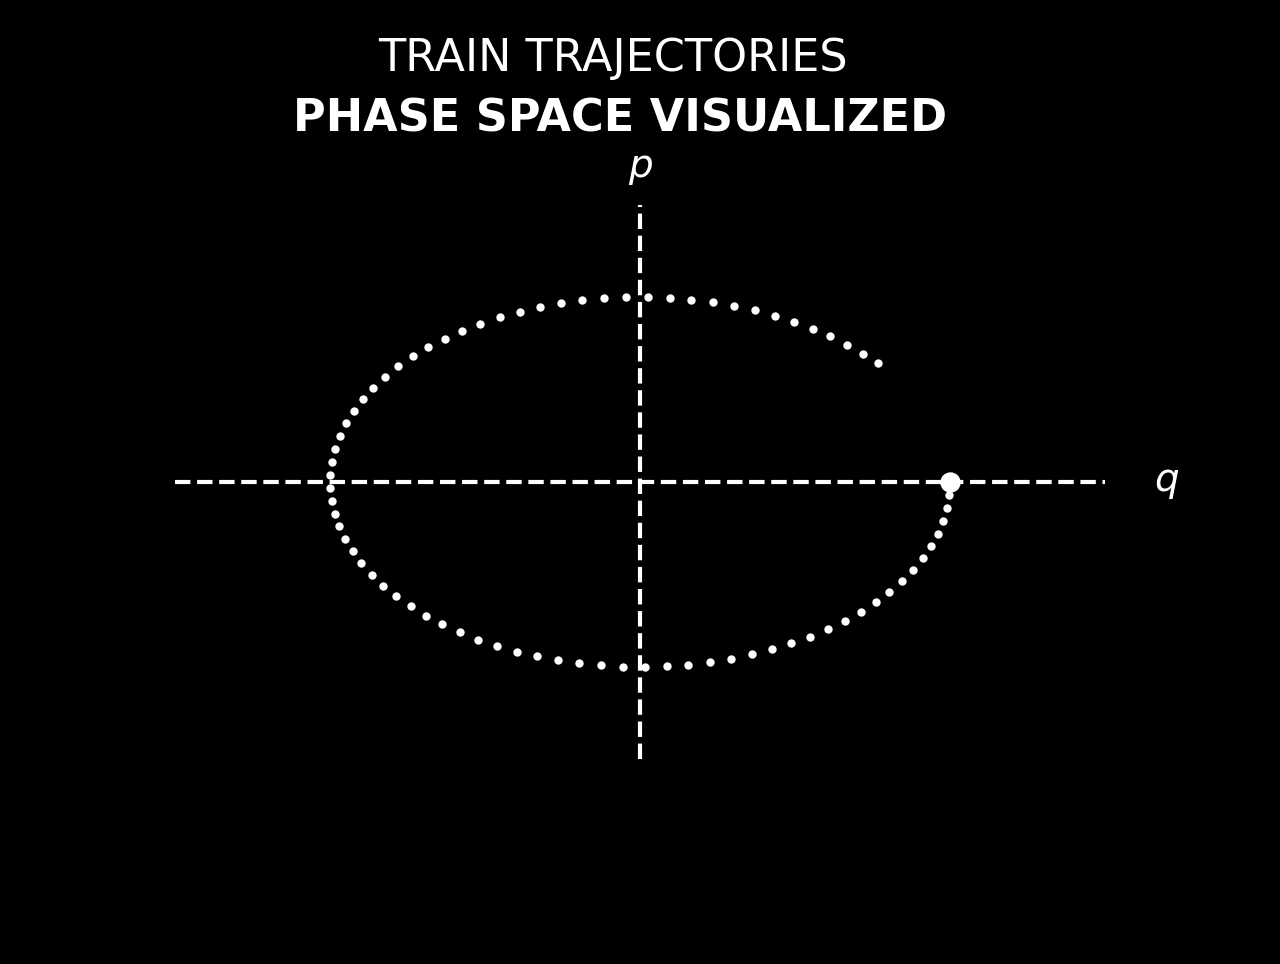

In [31]:
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    train_positions_rescaled,
    train_momentums_rescaled,
    title="TRAIN TRAJECTORIES",
    max_position=max_position,
    max_momentum=max_momentum,
)

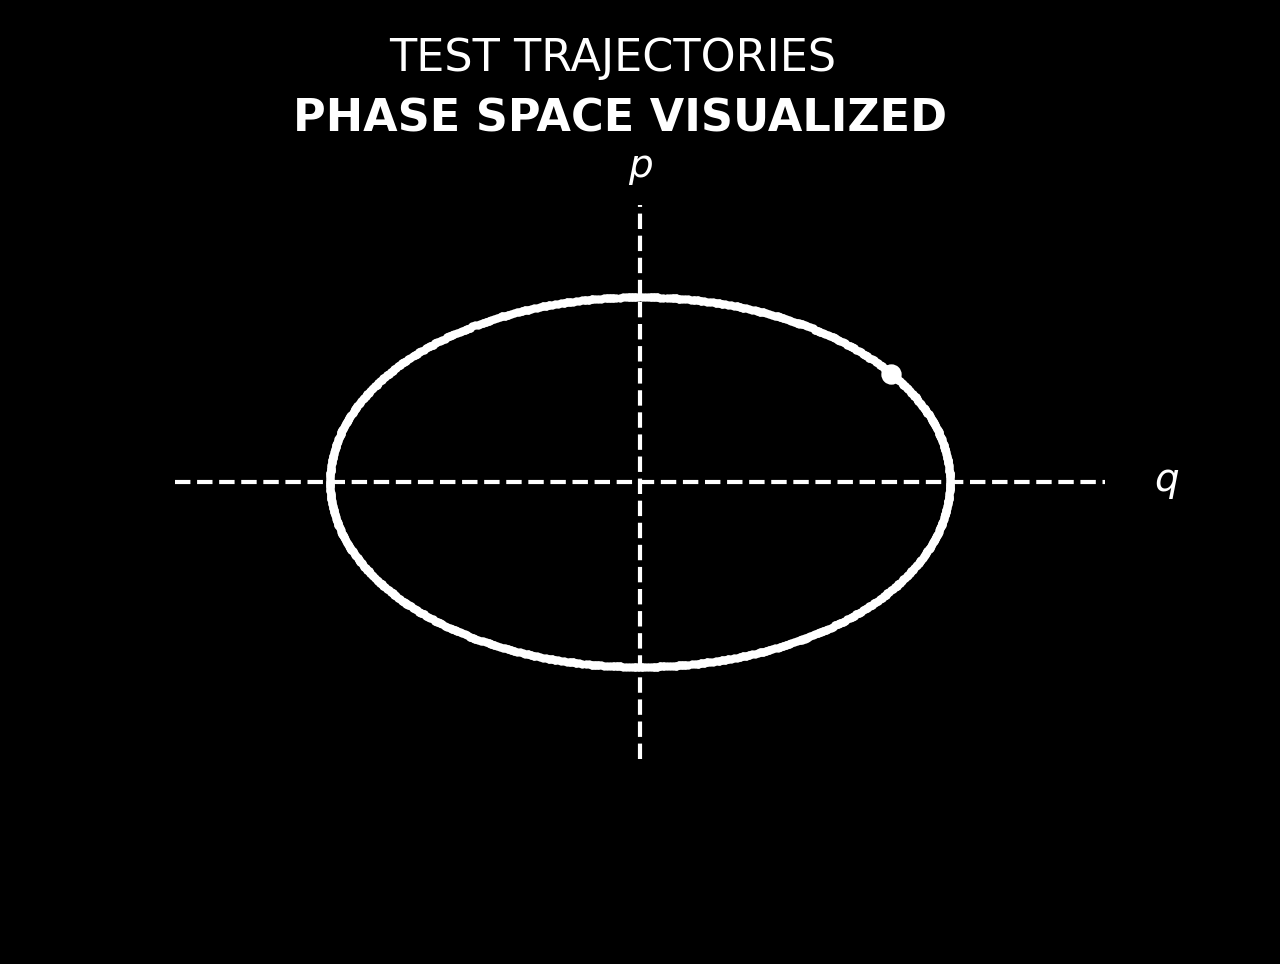

In [33]:
test_positions_rescaled, test_momentums_rescaled = train.inverse_transform_with_scaler(
    test_positions, test_momentums, scaler
)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    test_positions_rescaled,
    test_momentums_rescaled,
    title="TEST TRAJECTORIES",
    max_position=max_position,
    max_momentum=max_momentum,
)

### One-step Predictions

In [35]:
def predict_for_trajectory(
    positions_for_trajectory: chex.Array,
    momentums_for_trajectory: chex.Array,
    jump: int,
) -> Tuple[chex.Array, chex.Array]:
    (
        curr_positions,
        curr_momentums,
        target_positions,
        target_momentums,
    ) = train.get_coordinates_for_time_jump(
        positions_for_trajectory, momentums_for_trajectory, jump
    )
    (
        predicted_positions,
        predicted_momentums,
        auxiliary_predictions,
    ) = train.compute_predictions(
        state, curr_positions, curr_momentums, jump * config.time_delta
    )
    predicted_positions, predicted_momentums = train.inverse_transform_with_scaler(
        predicted_positions, predicted_momentums, scaler
    )
    return predicted_positions, predicted_momentums

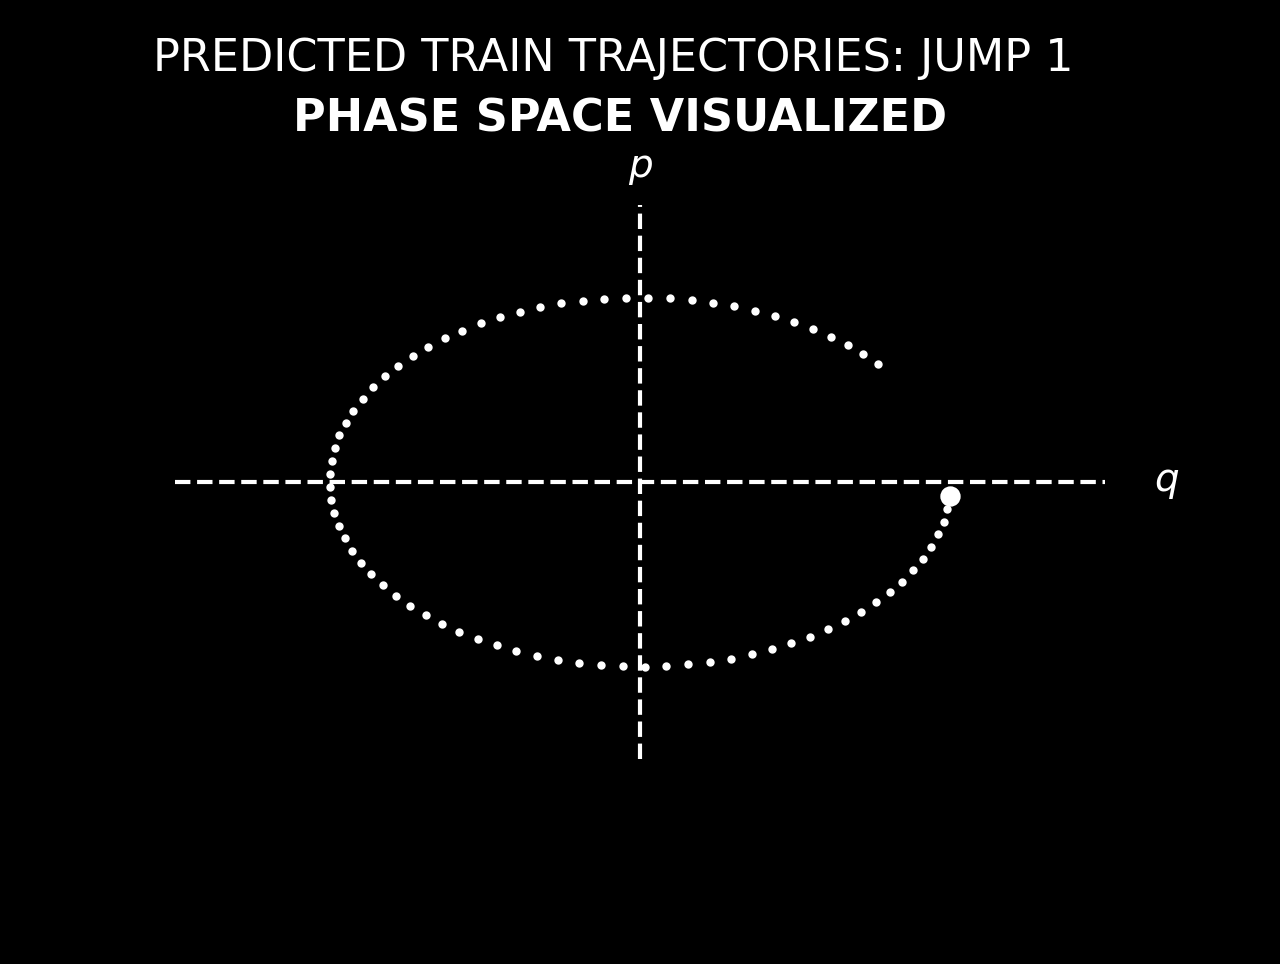

In [36]:
jump = 1
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

predicted_positions, predicted_momentums = predict_for_trajectory(
    train_positions, train_momentums, jump
)
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    predicted_positions,
    predicted_momentums,
    title=f"PREDICTED TRAIN TRAJECTORIES: JUMP {jump}",
    max_position=max_position,
    max_momentum=max_momentum,
)

(79, 1)


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

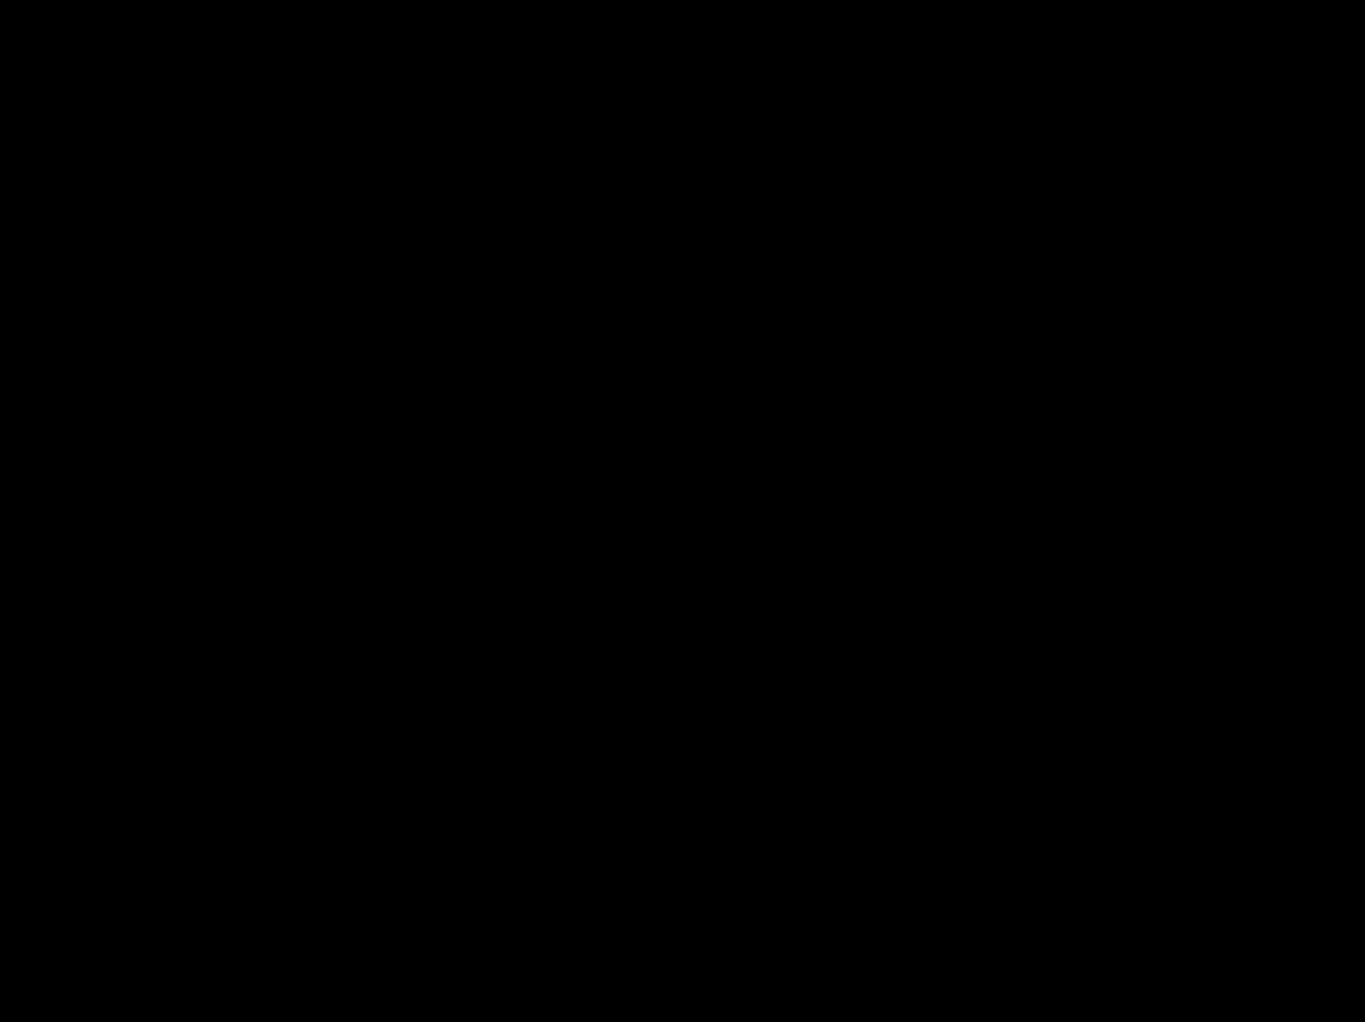

In [39]:
print(predicted_positions.shape)
train_one_step_predicted_trajectories_anim = (
    harmonic_motion_simulation.plot_coordinates(
        predicted_positions[:200, 0],
        predicted_momentums[:200, 0],
        jax.tree_map(lambda arr: arr[0], train_simulation_parameters),
        title=f"ONE-STEP PREDICTED TRAIN TRAJECTORIES: JUMP {jump}",
    )
)
train_one_step_predicted_trajectories_anim

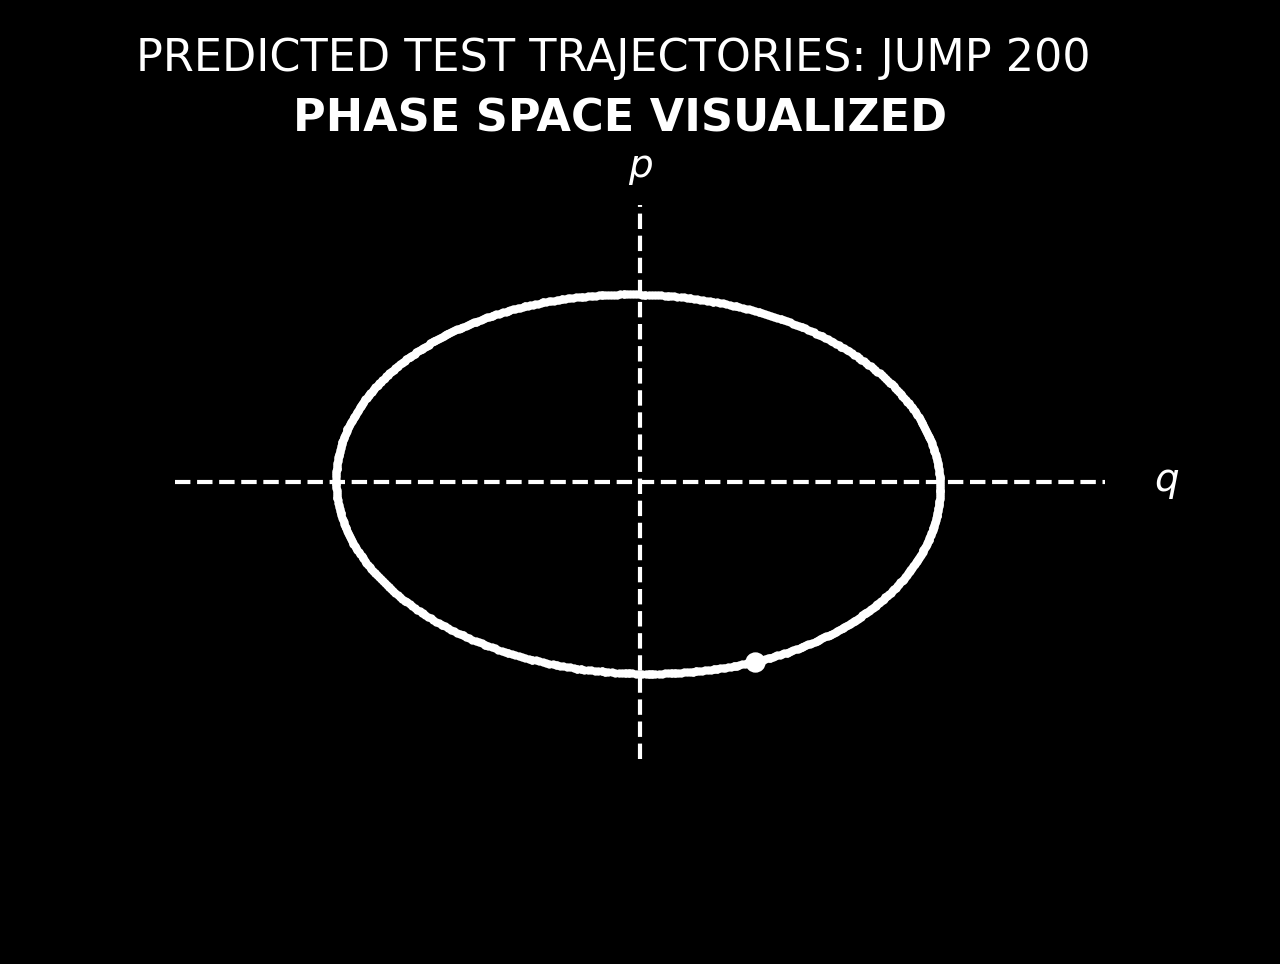

In [40]:
jump = 200
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

predicted_positions, predicted_momentums = predict_for_trajectory(
    test_positions, test_momentums, jump
)
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    predicted_positions,
    predicted_momentums,
    title=f"PREDICTED TEST TRAJECTORIES: JUMP {jump}",
    max_position=max_position,
    max_momentum=max_momentum,
)

In [ ]:
test_one_step_predicted_trajectories_anim = harmonic_motion_simulation.plot_coordinates(
    predicted_positions[:200, 0],
    predicted_momentums[:200, 0],
    jax.tree_map(lambda arr: arr[0], test_simulation_parameters),
    title=f"ONE-STEP PREDICTED TEST TRAJECTORIES: JUMP {jump}",
)
test_one_step_predicted_trajectories_anim

In [ ]:
test_one_step_predicted_trajectories_anim.save(
    "test_one_step_predicted_trajectories.gif"
)
files.download("test_one_step_predicted_trajectories.gif")

In [ ]:
test_one_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        predicted_positions[:100],
        predicted_momentums[:100],
        test_simulation_parameters,
        title=f"ONE-STEP PREDICTED TEST TRAJECTORIES: JUMP {jump}",
    )
)
test_one_step_predicted_trajectories_phase_space_anim

In [ ]:
test_one_step_predicted_trajectories_phase_space_anim.save(
    "test_one_step_predicted_trajectories_phase_space.gif"
)
files.download("test_one_step_predicted_trajectories_phase_space.gif")

### Distribution of Actions

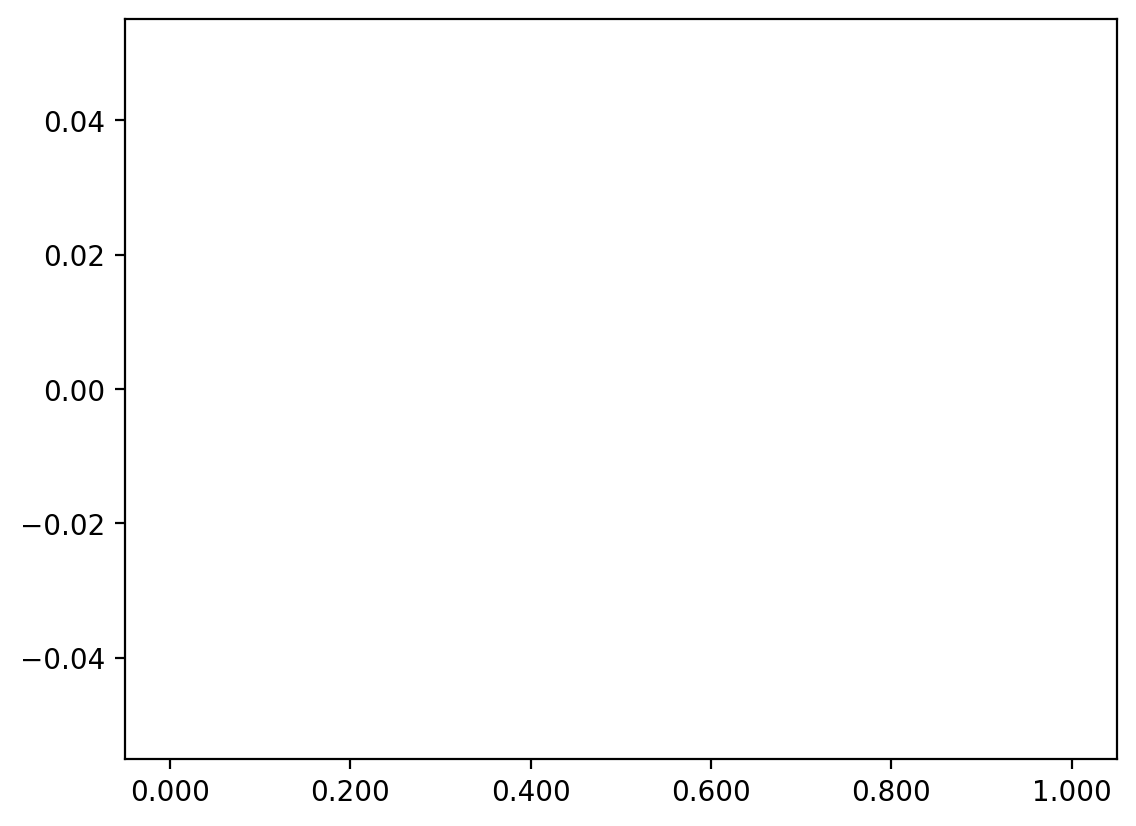

In [43]:
# Compute actions.
jump = 1
curr_positions, curr_momentums, *_ = train.get_coordinates_for_time_jump(
    train_positions[:1], train_momentums[:1], jump
)

_, _, auxiliary_predictions = state.apply_fn(
    state.params, curr_positions, curr_momentums, 0
)
plot_actions = auxiliary_predictions["actions"]
plot_angles = auxiliary_predictions["current_angles"]

actions = auxiliary_predictions["actions"]
actions = np.asarray(actions).flatten()
plt.hist(actions, bins=1000)
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.3f}"))
plt.show()

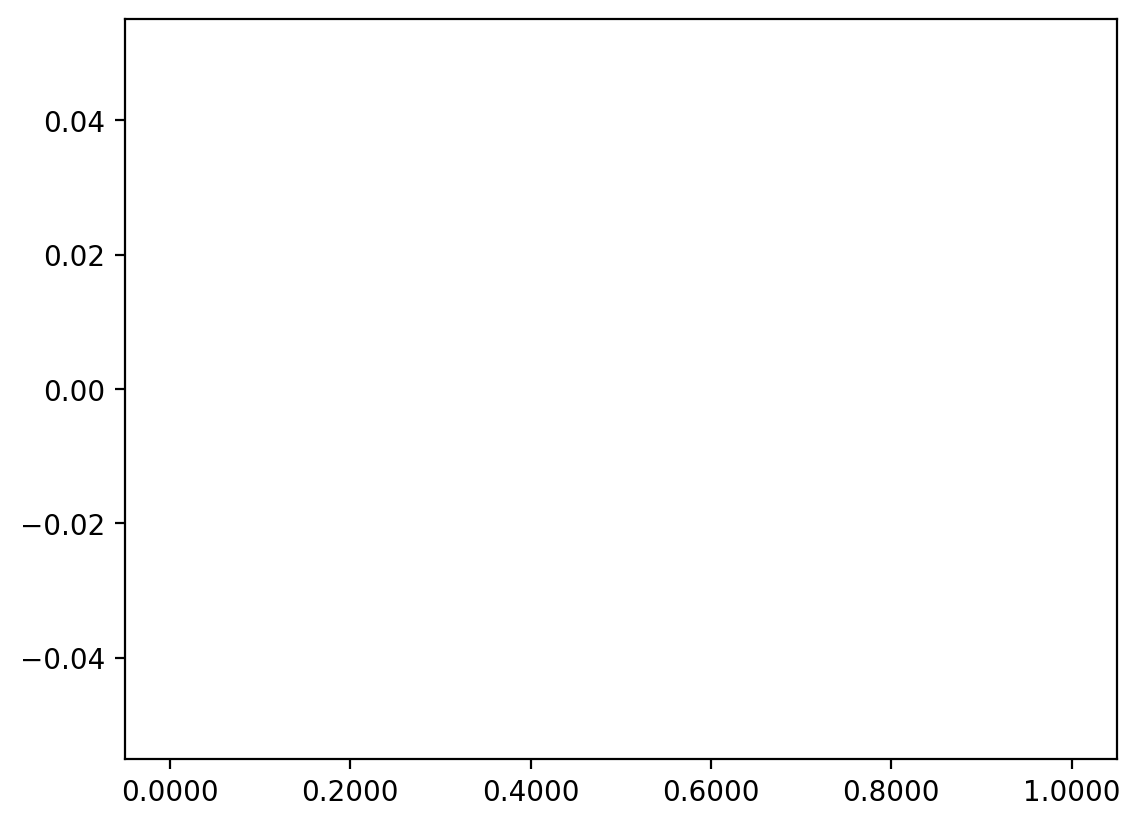

In [44]:
angular_velocities = auxiliary_predictions["angular_velocities"]
angular_velocities = np.asarray(angular_velocities).flatten()
plt.hist(angular_velocities, bins=1000)
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.4f}"))
plt.show()

### Non-Recursive Multi-Step Predictions

In [45]:
jump = 50
non_recursive_predictions = state.apply_fn(
    state.params,
    test_positions[:1],
    test_momentums[:1],
    jnp.arange(1, 500) * jump * config.time_delta,
    method=models.ActionAngleNetwork.predict_multi_step,
)
(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    non_recursive_multi_step_auxiliary_predictions,
) = non_recursive_predictions
non_recursive_multi_step_auxiliary_predictions[
    "angular_velocities"
], non_recursive_multi_step_auxiliary_predictions[
    "current_angles"
], non_recursive_multi_step_auxiliary_predictions[
    "future_angles"
][
    :10
]

(DeviceArray([[-0.07193061]], dtype=float32),
 DeviceArray([[0.28201178]], dtype=float32),
 DeviceArray([[ 2.9686668 ],
              [-0.6278634 ],
              [ 2.0587914 ],
              [-1.5377386 ],
              [ 1.148915  ],
              [-2.4476168 ],
              [ 0.23903966],
              [ 2.9256942 ],
              [-0.6708348 ],
              [ 2.0158217 ]], dtype=float32))

In [ ]:
(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
) = train.inverse_transform_with_scaler(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    scaler,
)

In [ ]:
fig = harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    non_recursive_multi_step_predicted_positions[:100],
    non_recursive_multi_step_predicted_momentums[:100],
    title=f"PREDICTED TEST TRAJECTORIES: JUMP {jump}",
)
fig

In [ ]:
fig.savefig(
    f"test_multi_step_predicted_phase_space_jump_{jump}.pdf",
    dpi=1000,
    bbox_inches="tight",
    pad_inches=0,
)
files.download("test_multi_step_predicted_phase_space_jump_{jump}.pdf")

In [ ]:
test_multi_step_predicted_trajectories_anim = plot_coordinates(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    simulation_parameters,
    title="NON-RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
)
test_multi_step_predicted_trajectories_anim

In [ ]:
test_multi_step_predicted_trajectories_anim.save(
    "test_non_recursive_multi_step_predicted_trajectories.gif"
)
files.download("test_non_recursive_multi_step_predicted_trajectories.gif")

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        non_recursive_multi_step_predicted_positions[:100],
        non_recursive_multi_step_predicted_momentums[:100],
        test_simulation_parameters,
        title=f"PREDICTED TEST TRAJECTORIES: JUMP {jump}",
    )
)
test_multi_step_predicted_trajectories_phase_space_anim

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim.save(
    f"test_non_recursive_multi_step_predicted_trajectories_phase_space_jump_{jump}.gif"
)
files.download(
    f"test_non_recursive_multi_step_predicted_trajectories_phase_space_jump_{jump}.gif"
)

### Recursive Multi-Step Predictions

In [ ]:
def predict_next_step(carry, _):
    current_position, current_momentum = carry
    (
        predicted_position,
        predicted_momentum,
        auxiliary_predictions,
    ) = train.compute_predictions(
        state, current_position, current_momentum, config.time_delta
    )
    return (predicted_position, predicted_momentum), (
        predicted_position,
        predicted_momentum,
        auxiliary_predictions,
    )


_, recursive_predictions = jax.lax.scan(
    predict_next_step, (test_positions[0, :1], test_momentums[0, :1]), None, length=1000
)
(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    recursive_multi_step_auxiliary_predictions,
) = recursive_predictions
recursive_multi_step_auxiliary_predictions["angular_velocities"][
    0
], recursive_multi_step_auxiliary_predictions["current_angles"][
    :10
], recursive_multi_step_auxiliary_predictions[
    "future_angles"
][
    :10
]

In [ ]:
recursive_multi_step_predicted_positions[0], recursive_multi_step_predicted_momentums[0]

In [ ]:
(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
) = train.inverse_transform_with_scaler(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    scaler,
)

In [ ]:
recursive_multi_step_predicted_positions[0], recursive_multi_step_predicted_momentums[0]

In [ ]:
test_multi_step_predicted_trajectories_anim = (
    harmonic_motion_simulation.plot_coordinates(
        recursive_multi_step_predicted_positions[:200],
        recursive_multi_step_predicted_momentums[:200],
        simulation_parameters,
        title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
    )
)
test_multi_step_predicted_trajectories_anim

In [ ]:
test_multi_step_predicted_trajectories_anim.save(
    "test_recursive_multi_step_predicted_trajectories.gif"
)
files.download("test_recursive_multi_step_predicted_trajectories.gif")

In [ ]:
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
)

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        recursive_multi_step_predicted_positions[:200],
        recursive_multi_step_predicted_momentums[:200],
        simulation_parameters,
        title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
    )
)
test_multi_step_predicted_trajectories_phase_space_anim

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim.save(
    "test_recursive_multi_step_predicted_trajectories_phase_space.gif"
)
files.download("test_recursive_multi_step_predicted_trajectories_phase_space.gif")

### True Trajectories

In [ ]:
test_true_trajectories_anim = harmonic_motion_simulation.plot_coordinates(
    test_target_positions[:200],
    test_target_momentums[:200],
    simulation_parameters,
    title="TRUE TEST TRAJECTORIES",
)
test_true_trajectories_anim

In [ ]:
test_true_trajectories_anim.save("test_true_trajectories.gif")
files.download("test_true_trajectories.gif")